In [11]:
import numpy as np
import sys
import math
import matplotlib.pyplot as plt
from matplotlib.image import imread
# import tensorflow only to take the data, !! NO prebuilt optimization was used !!
import tensorflow as tf
import pickle
import os
import time


In [12]:
(X_train, Y_train_hot), (X_test, Y_test_hot) = tf.keras.datasets.mnist.load_data()

In [13]:
train_images = X_train
test_images = X_test

m = X_train.shape[0]
m_test = X_test.shape[0]
n_x = X_train.shape[1] * X_train.shape[2]
c = 10 # 10 classes

# change 28*28 images into a (n_x * m) matrix
X_train = X_train.reshape(m, -1).T / 255
X_test = X_test.reshape(m_test, -1).T / 255

# normalize input X
mu_X = 1/m * np.sum(X_train, axis = 1, keepdims = True)
VAR_X = 1/m * np.sum((X_train - mu_X) **2)
X_train = (X_train - mu_X) / VAR_X

# convert Y_train from one hot to (c*m) matrix 
Y_train = np.zeros((c, m))
Y_train[Y_train_hot, np.arange(m)] = 1
# convert Y_test from one hot to (c*m_test) matrix
Y_test = np.zeros((c, m_test))
Y_test[Y_test_hot, np.arange(m_test)] = 1

L = 3 # not including the input layer
layers = [n_x, 1000, 400, c]

In [14]:
def pretrain_load():
    parameters = {}
    # you need to download the pretrained model and replace my location by your download file location
    # below is my file location
    Wfile = open(r"C:\Users\nhunh\Params_update_4", "rb")
    parameters = pickle.load(Wfile)
    Wfile.close()
    
    return parameters

In [15]:
# function to initialize learning parameters for each layer
def initialize_params(layers):
    params = {}
    for l in range(1, L+1):
        # He et. al, 2015 initialization
        params["W" + str(l)] = np.random.randn(layers[l], layers[l-1]) * np.sqrt(2 / layers[l-1])
        params["b" + str(l)] = np.zeros((layers[l], 1))
    
    return params

In [16]:
# compute activation Relu
def relu(Z):
    return np.maximum(0, Z)

# compute activaiton Softmax
def softmax(Z):
    T = np.exp(Z)
    return T / (np.sum(T, axis = 0, keepdims = True))

def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))


In [17]:
# compute dZ if the activation function is ReLU
def d_relu(Z):
    return (Z > 0).astype(float)

def d_sigmoid(A):
    return A * (1-A)

In [18]:
# generate random mini-batches with given size
def random_minibatches(X, Y, mini_batch_size):
    mini_batches = []
    
    # randomly shuffle the data set
    permu = list(np.random.permutation(m))
    X_shuffled = X[:, permu]
    Y_shuffled = Y[:, permu]
    
    num_full_mini = m // mini_batch_size
    
    for i in range(0, num_full_mini):
        mini_X = X_shuffled[:, i * mini_batch_size : (i+1) * mini_batch_size]
        mini_Y = Y_shuffled[:, i * mini_batch_size : (i+1) * mini_batch_size]
        mini_batches.append((mini_X, mini_Y))
    
    if m % mini_batch_size != 0:
        mini_X = X_shuffled[:, m - m % mini_batch_size : m+1]
        mini_Y = Y_shuffled[:, m - m % mini_batch_size : m+1]
        mini_batches.append((mini_X, mini_Y))
        
    return mini_batches

In [19]:
# adaptive momentum initialization
def initialization_adam(L):
    V = {} # for momentum gd
    S = {}
    
    for l in range(1, L+1):
        V["dW" + str(l)] = 0
        V["db" + str(l)] = 0
        S["dW" + str(l)] = 0
        S["db" + str(l)] = 0
    
    return V, S

In [20]:
# function to do one single forward propagation
def forward_single_layer(A_prev, W_cur, b_cur, l, keep_prob, activation):
    cache = []
    Z_cur = np.dot(W_cur, A_prev) + b_cur
    
    cache = [A_prev, Z_cur, W_cur, b_cur]
    
    if activation == "sigmoid":
        A_cur = 1 / (1 + np.exp(-Z_cur))
        cache.append("sigmoid")
    elif activation == "relu":
        A_cur = relu(Z_cur)
        cache.append("relu")
    elif activation == "softmax":
        A_cur = softmax(Z_cur)
        cache.append("softmax")
    
    # drop-out to prevent overfitting
    keep_or_drop = np.random.rand(A_cur.shape[0], A_cur.shape[1])
    keep_or_drop = (keep_or_drop < keep_prob).astype(float)
    A_cur *= keep_or_drop
    A_cur /= keep_prob
    
    cache.append(keep_or_drop)
    cache.append(keep_prob)
    
    return A_cur, cache


# function to do forward propagation through all layers
def forward_multi_layers(X, params, L, keep_prob_s):
    # keep_prob_s is the keep_prob for different layers
    caches = []
    A_prev = X
    
    
    for l in range(1, L):
        A, cache = forward_single_layer(A_prev, params["W" + str(l)], params["b" + str(l)], l, keep_prob_s[l-1], activation = "relu")
        caches.append(cache)
        A_prev = A
        
        
    AL, cache = forward_single_layer(A_prev, params["W" + str(L)], params["b" + str(L)], L, keep_prob = 1., activation = "softmax")
    caches.append(cache)
    
    return AL, caches

In [21]:
# function to compute the loss of one batch
def compute_Loss(AL, Y):
    # this is not the exact loss of the current mini-batch, I use this to compute the cost after each epoch only
    return - np.sum(np.sum(Y * np.log(AL), axis = 0, keepdims = True), axis = 1) 

In [22]:
# this function perform backprop to 1 layer back
def backprop_single_layer(dA, cache, batch_size):
    A_prev, Z_cur, W_cur, b_cur, _ , keep_or_drop, keep_prob = cache
    grad = {}
    
    # I assume that we are doing backprop on hidden layers, all of which I use "sigmoid" activation function
    dA *= keep_or_drop
    dA /= keep_prob
    dZ = dA * d_relu(Z_cur)
    
    dW = 1/batch_size * np.dot(dZ, A_prev.T)
    db = 1/batch_size * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W_cur.T, dZ)
    
    return dA_prev, dW, db

# this function perform backpropagation throughout all layers
def backprop_multi_layers(AL, Y, caches, batch_size):
    assert(AL.shape == Y.shape)
    dAL = AL - Y # derivative of the cost to the final layer (softmax function)
    assert(AL.shape[1] == batch_size)
    
    dW = [None] * (L+1)
    db = [None] * (L+1)
    
    dA_prev = dAL
    for l in reversed(range(1, L+1)):
        dA, dW[l], db[l] = backprop_single_layer(dA_prev, caches[l-1], batch_size = batch_size)
        dA_prev = dA
    
    return dW, db

In [23]:
# use adam optimization to update parameters
def update(params, V, S, t, dW, db, alpha, beta1 = 0.8, beta2 = 0.999, epsilon = 1e-8):
    V_corrected = {}
    S_corrected = {}
    for l in range(1, L+1):
        
        V["dW" + str(l)] = beta1 * V["dW" + str(l)] + (1-beta1) * dW[l]
        V["db" + str(l)] = beta1 * V["db" + str(l)] + (1-beta1) * db[l]
        V_corrected["dW" + str(l)] = V["dW" + str(l)] / (1 - np.power(beta1, t))
        V_corrected["db" + str(l)] = V["db" + str(l)] / (1 - np.power(beta1, t))
        
        S["dW" + str(l)] = beta2 * S["dW" + str(l)] + (1-beta2) * (dW[l] **2)
        S["db" + str(l)] = beta2 * S["db" + str(l)] + (1-beta2) * (db[l] **2)
        S_corrected["dW" + str(l)] = S["dW" + str(l)] / (1 - np.power(beta2, t))
        S_corrected["db" + str(l)] = S["db" + str(l)] / (1 - np.power(beta2, t))
        
        
        
        params["W" + str(l)] -= alpha * V_corrected["dW" + str(l)] / np.sqrt((S_corrected["dW" + str(l)]) + epsilon)
        params["b" + str(l)] -= alpha * V_corrected["db" + str(l)] / np.sqrt((S_corrected["db" + str(l)]) + epsilon)
        
        #params["W" + str(l)] -= alpha * dW[l]
        #params["b" + str(l)] -= alpha * db[l]
        
    return params, V, S

In [24]:
def train_neural_network(alpha, num_epoch, alpha_decay_rate, keep_prob_layers):
    params = initialize_params(layers)
    V, S = initialization_adam(L)
    mini_batches = random_minibatches(X_train, Y_train, mini_batch_size = 2**8)
    t = 1
    
    for num_epoch in range(0, num_epoch):
        cost = 0
        for mini in mini_batches:
            (mini_X, mini_Y) = mini
            cur_batch_size = mini_X.shape[1]
            
            # learning rate decay
            alpha = alpha / (1 + alpha_decay_rate * num_epoch)

            AL, caches = forward_multi_layers(mini_X, params, L, keep_prob_layers)
            cost += compute_Loss(AL, mini_Y)

            dW, db = backprop_multi_layers(AL, mini_Y, caches, batch_size = cur_batch_size)
            

            params, V, S = update(params, V, S, t, dW, db, alpha = alpha)
            t += 1
        
        print("Epoch " + str(num_epoch+1) + " Training...")
        print("Cost after epoch " + str(num_epoch+1) + " = " + str(1/m * cost))
    return params

In [25]:
def predict(X, params):
    AL, _ = forward_multi_layers(X, params, L, keep_prob_s = [1, 1, 1]) # we have to turn off drop out during test time
    
    return AL

In [ ]:
# Start training, you can try out different hyperparameters like learning rate as well as modify beta1 and beta2 for adam above
# My choice of hyperparameters are probably not too good, you can try better ones

print("Start")
accuracy_test = []
params = []

for i in range(0,5):
    parameters = train_neural_network(alpha = 0.005, num_epoch = 10, alpha_decay_rate = 1, 
                                  keep_prob_layers = [0.5, 0.5, 1])
    pred_test = predict(X_test, parameters)
    print(np.sum(np.argmax(pred_test, axis = 0) == Y_test_hot) / m_test * 100)
    print()
    accuracy_test.append(np.sum(np.argmax(pred_test, axis = 0) == Y_test_hot) / m_test * 100)
    params.append(parameters)

# this is to test your trained model above   
max_accuracy_idx = np.argmax(accuracy_test)
parameters_final = params[max_accuracy_idx]

pred_train = predict(X_train, parameters_final)
print("Accuracy on training set: " + str( np.sum(np.argmax(pred_train, axis = 0) == Y_train_hot) / m * 100 ) + "%")
print("Accuracy on test set: " + str(accuracy_test[max_accuracy_idx]) + "%")

In [ ]:
# create a file locally to save learned parameters
#params_file = open("Name_of_the file", "w+")
#params_file.close()

#Project_path = r"Your_file_location"

#parameters_final
#params_file = open(Project_path, "wb")
#pickle.dump(parameters_final, params_file)

#params_file.close()

In [28]:
# this is the parameters of my pretrained model, with the accuracy of 95.08% on the test set
def pretrain_model_accuracy():
    params = pretrain_load()

    pred_train = predict(X_train, params)
    pred_test = predict(X_test, params)

    # this is the accuracy of my model on traing set and on test set
    print("Accuracy on training set: " + str( np.sum(np.argmax(pred_train, axis = 0) == Y_train_hot) / m * 100 ) + "%")
    print("Accuracy on test set: " + str( np.sum(np.argmax(pred_test, axis = 0) == Y_test_hot) / m_test * 100 ) + "%")
    

In [29]:
# some examples of the digits that pre-trained model predicts correctly
def test_correct_prediction():
    params = pretrain_load()
    pred_test = predict(X_test, params)
    confidence = np.max(pred_test, axis = 0)
    
    res = (np.argmax(pred_test, axis = 0) == Y_test_hot).astype(float)
    i=0
    correct = []
    for j in res:
        if(len(correct) == 20):
            break
            
        if j == 1:
            correct.append(i)
        i +=1
        
    for j in correct[10:20]:
        print()
        plt.imshow(test_images[j])
        plt.show()
        print("Correct prediction: ")
        print("Model's prediction: " + str(np.argmax(pred_test, axis = 0)[j]))
        print("Confidence        :"  + str(confidence[j] * 100) + " %")
        print("Ground truth      : " + str((Y_test_hot)[j]))
        print("===============================")
        print("===============================")        


In [30]:
# some examples of the digits that pre-trained model predicts correctly
def test_misclassify():
    params = pretrain_load()
    pred_test = predict(X_test, params)
    confidence = np.max(pred_test, axis = 0)
    
    res = (np.argmax(pred_test, axis = 0) == Y_test_hot).astype(float)
    i=0
    correct = []
    for j in res:
        if(len(correct) == 20):
            break
            
        if j == 0:
            correct.append(i)
        i +=1
        
    for j in correct[7:10]:
        print()
        plt.imshow(test_images[j])
        plt.show()
        print("Wrong prediction: ")
        print("Model's prediction: " + str(np.argmax(pred_test, axis = 0)[j]))
        print("Confidence        :"  + str(confidence[j] * 100) + " %")
        print("Ground truth      : " + str((Y_test_hot)[j]))
        print("===============================")
        print("===============================")        


In [31]:
# This function is used to show the accuracy of pretrained model on training and test set, 
# and display some images in the test set
def pre_trained_result():
    print("SOME EXAMPLES: ")
    print()
    pretrain_model_accuracy()
    print()
    test_correct_prediction()
    print()
    test_misclassify()

SOME EXAMPLES: 



C:\Users\nhunh\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


Accuracy on training set: 95.36666666666666%
Accuracy on test set: 95.08%




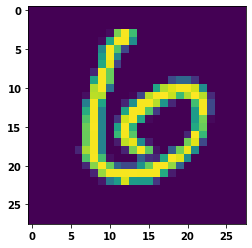

Correct prediction: 
Model's prediction: 6
Confidence        :100.0 %
Ground truth      : 6



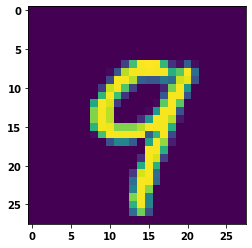

Correct prediction: 
Model's prediction: 9
Confidence        :100.0 %
Ground truth      : 9



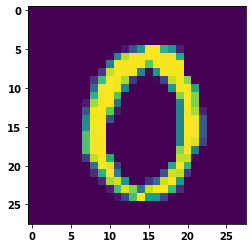

Correct prediction: 
Model's prediction: 0
Confidence        :100.0 %
Ground truth      : 0



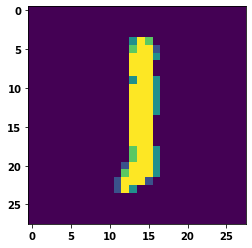

Correct prediction: 
Model's prediction: 1
Confidence        :100.0 %
Ground truth      : 1



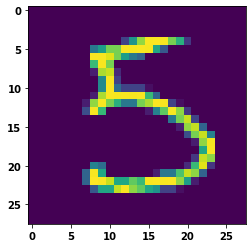

Correct prediction: 
Model's prediction: 5
Confidence        :100.0 %
Ground truth      : 5



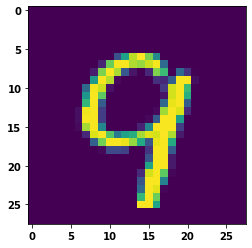

Correct prediction: 
Model's prediction: 9
Confidence        :100.0 %
Ground truth      : 9



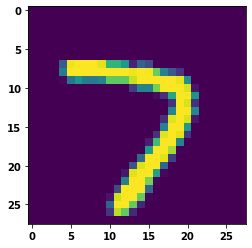

Correct prediction: 
Model's prediction: 7
Confidence        :100.0 %
Ground truth      : 7



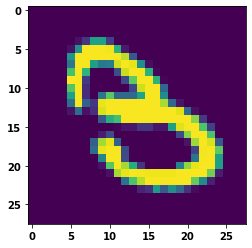

Correct prediction: 
Model's prediction: 3
Confidence        :100.0 %
Ground truth      : 3



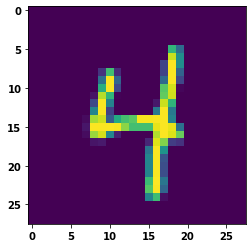

Correct prediction: 
Model's prediction: 4
Confidence        :100.0 %
Ground truth      : 4



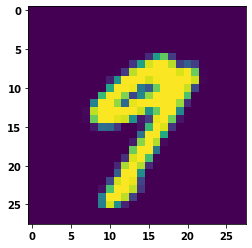

Correct prediction: 
Model's prediction: 9
Confidence        :100.0 %
Ground truth      : 9




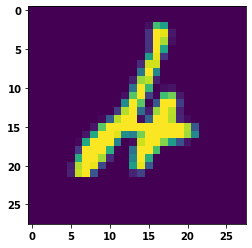

Wrong prediction: 
Model's prediction: 6
Confidence        :99.94388003897136 %
Ground truth      : 4



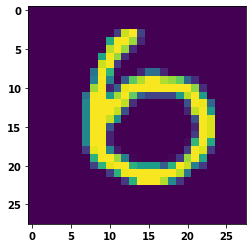

Wrong prediction: 
Model's prediction: 0
Confidence        :100.0 %
Ground truth      : 6



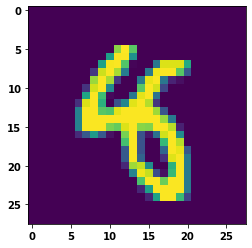

Wrong prediction: 
Model's prediction: 4
Confidence        :100.0 %
Ground truth      : 8


In [32]:
pre_trained_result()

In [107]:
#img = test_images[290]
#print(img.shape)
#plt.imshow(img)